In [50]:
import pandas as pd
import numpy as np

In [51]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from matplotlib import pyplot as plt
import seaborn as sns


# --------------------------- Resident class ---------------------------
class Resident:
    """
    A resident in the building with a role and behavior pattern.
    Generates elevator arrival times (leave home, return home) based on role.
    """
    def __init__(self, home_floor, role, building):
        self.home_floor = home_floor
        self.role = role
        self.regular_leave = {0:[],1:[],2:[],3:[],4:[],5:[]}
        self.regular_return = {0:[],1:[],2:[],3:[],4:[],5:[]}
        self.generate_regular_schedule()
        self.building = building
        
        
    def generate_regular_schedule(self):
        """Generate regular leave/return times based on role."""
        if self.role == "worker":
            for day in range(5):  # Monday to Friday
                leave_hour = random.randint(7,9)
                leave_minute = random.randint(0,59)
                return_hour = random.randint(17,21)
                return_minute = random.randint(0,59)
                self.regular_leave[day].append(self._time_with_offset(leave_hour, leave_minute, sigma=10))
                self.regular_return[day].append(self._time_with_offset(return_hour, return_minute, sigma=20))
            
            if random.random() > 0.7:
                self.regular_leave[day].append(self._time_with_offset(leave_hour, leave_minute, sigma=10))
                self.regular_return[day].append(self._time_with_offset(return_hour, return_minute, sigma=20))
        
        elif self.role == "university":
            for day in range(5):  # Monday to Friday
                leave_hour = random.choice([7,8,12,13])
                leave_minute = random.randint(30,59)
                return_hour = leave_hour + random.randint(4,9)
                return_minute = random.randint(0,59)
                self.regular_leave[day].append(self._time_with_offset(leave_hour, leave_minute, sigma=10))
                self.regular_return[day].append(self._time_with_offset(return_hour, return_minute, sigma=30))
                
        elif self.role == "school":
            for day in range(5):  # Monday to Friday
                leave_hour = 6
                leave_minute = random.randint(0,30)
                return_hour = 14 + random.randint(0,2)
                return_minute = random.randint(0,30)
                self.regular_leave[day].append(self._time_with_offset(leave_hour, leave_minute, sigma=5))
                self.regular_return[day].append(self._time_with_offset(return_hour, return_minute, sigma=10))

    def non_regular_trip(self):
        """Generate non-regular trips for no-regular days."""
        trips = []
        num_trips = random.choices([0, 1, 2], weights=[0.3, 0.5, 0.2])[0]

        for _ in range(num_trips):
            if len(trips) == 0:
                # 第一次出门，8:00–19:00之间
                leave_hour_min = 8
            else:
                # 上一趟已经回来了，下一趟最早从上一趟回家后一小时开始
                last_return_sec = trips[-1][1]
                last_return_hour = last_return_sec // 3600
                if last_return_hour >= 22:
                    break  # 太晚了，不再安排新行程
                leave_hour_min = last_return_hour + 1

            leave_hour_max = 22  # 最晚出门时间 22 点前
            if leave_hour_min > leave_hour_max:
                break

            leave_hour = random.randint(leave_hour_min, leave_hour_max)
            leave_minute = random.randint(0, 59)
            leave_time = self._time_with_offset(leave_hour, leave_minute, sigma=30)

            # 根据真实 leave_time 再算一次小时，避免偏移后超过 23 点
            leave_hour_actual = leave_time // 3600
            if leave_hour_actual >= 23:
                leave_hour_actual = 22

            # 回家时间：离开 1–4 小时内，且不超过 23 点
            return_hour_min = min(leave_hour_actual + 1, 23)
            return_hour_max = min(leave_hour_actual + 4, 23)
            if return_hour_min > return_hour_max:
                return_hour_min = return_hour_max

            return_hour = random.randint(return_hour_min, return_hour_max)
            return_minute = random.randint(0, 59)
            return_time = self._time_with_offset(return_hour, return_minute, sigma=30)

            trips.append((leave_time, return_time))

        return trips
            
            
    def _time_with_offset(self, base_hour, base_minute, mu=0, sigma=2):
        """Return datetime offset by Gaussian noise (minutes)."""
        offset = int(np.random.normal(mu, sigma))
        return base_hour * 60*60 + (base_minute + offset)*60 + random.randint(0,59)
    
    def generate_internal_trips(self):
        """
        Generate random internal floor-to-floor trips.
        These represent moving between floors inside the building
        without going to ground floor.
        """
        internal_events = []

        if random.random() < 0.3:  # 30% chance of internal trips
            # 选择 origin (不能是 ground floor)
            origin = random.randint(1, self.building.num_floors)

            # 选择 destination（不能与 origin 相同）
            dest = origin
            while dest == origin:
                dest = random.randint(1, self.building.num_floors)

            # 时间在 08:00 - 21:00 之间随机（可调整）
            hour = random.randint(8, 21)
            minute = random.randint(0, 59)
            internal_time = self._time_with_offset(hour, minute, sigma=15)

            internal_events.append({
                "date": None,   # 稍后在 generate_daily_events() 填入
                "weekday": None,
                "time_second": internal_time,
                "origin": origin,
                "destination": dest,
                "move_type": "internal"
            })

        return internal_events


    def generate_daily_events(self, date):
        """
        Generate times (in minutes from 00:00) when the resident uses the elevator.
        Returns a list of dicts: { "time": int, "floor": int, "direction": str }
        """
        weekday = date.weekday()   # Monday=0, Sunday=6
        events = []

        # Regular trips
        if weekday <6:
            if self.regular_leave[weekday]:
                for leave_time in self.regular_leave.get(weekday, []):
                    events.append({
                        "date": date,
                        "weekday": weekday,
                        "time_second": leave_time,
                        "origin": self.home_floor,
                        "destination": self.building.ground_floor,
                        "move_type": "down"
                    })
                for return_time in self.regular_return.get(weekday, []):
                    events.append({
                        "date": date,
                        "weekday": weekday,
                        "time_second": return_time,
                        "origin": self.building.ground_floor,
                        "destination": self.home_floor,
                        "move_type": "up"
                    })
            else:
                # Non-regular trips
                trips = self.non_regular_trip()
                for leave_time, return_time in trips:
                    events.append({
                        "date": date,
                        "weekday": weekday,
                        "time_second": leave_time,
                        "origin": self.home_floor,
                        "destination": self.building.ground_floor,
                        "move_type": "down"
                    })
                    events.append({
                        "date": date,
                        "weekday": weekday,
                        "time_second": return_time,
                        "origin": self.building.ground_floor,
                        "destination": self.home_floor,
                        "move_type": "up"
                    })
        elif weekday == 6:  # Sunday
            trips = self.non_regular_trip()
            for leave_time, return_time in trips:
                events.append({
                        "date": date,
                        "weekday": weekday,
                        "time_second": leave_time,
                        "origin": self.home_floor,
                        "destination": self.building.ground_floor,
                        "move_type": "down"
                    })
                events.append({
                        "date": date,
                        "weekday": weekday,
                        "time_second": return_time,
                        "origin": self.building.ground_floor,
                        "destination": self.home_floor,
                        "move_type": "up"
                    })
        # Internal trips
        internal_events = self.generate_internal_trips()
        for event in internal_events:
            event["date"] = date
            event["weekday"] = weekday
        events.extend(internal_events)
        return events


# --------------------------- Building class ---------------------------
class Building:
    """
    A building that generates residents and simulates all elevator arrival events.
    """
    def __init__(self, num_floors, num_residents):
        self.num_floors = num_floors
        self.ground_floor = 0
        self.resident_floor = {floor: [] for floor in range(self.ground_floor+1, num_floors + 1)}

        # Randomly place residents
        self.residents = []
        for _ in range(num_residents):
            floor = random.randint(1, num_floors)

            # random role distribution
            role = random.choices(
                ["worker", "university", "school", "unemployed"],
                weights=[0.45, 0.25, 0.15, 0.15]   # adjustable
            )[0]

            self.residents.append(Resident(floor, role, self))

    def simulate_day(self, date):
        """
        Simulate all elevator arrivals for a given date.
        Returns list of events sorted by time.
        """
        all_events = []

        for r in self.residents:
            events = r.generate_daily_events(date)
            all_events.extend(events)

        # sort by time
        all_events.sort(key=lambda x: x["time_second"])
        return all_events

    def simulate_days(self, start_date, days):
        """Simulate multiple days and return a full event list."""
        events = []
        date = start_date
        for _ in range(days):
            day_events = self.simulate_day(date)
            events.extend(day_events)
            date += timedelta(days=1)
        # sort by date and time
        events.sort(key=lambda x: (x["date"], x["time_second"]))
        
        # convert to DataFrame for easier handling
        events = pd.DataFrame(events)
        events['timestamp'] = pd.to_datetime(events['date']) + pd.to_timedelta(events['time_second'], unit='s')
        return events


In [ ]:
low_rise_low_dense_building = Building(num_floors=10, num_residents=500)
low_rise_low_dense_arrivals = low_rise_low_dense_building.simulate_days(
    start_date=datetime(2025, 1, 1),
    days=90)
low_rise_low_dense_arrivals

,date,weekday,time_second,origin,destination,move_type,timestamp
0,2025-01-01,2,21180,2,0,down,2025-01-01 05:53:00
1,2025-01-01,2,21210,7,0,down,2025-01-01 05:53:30
2,2025-01-01,2,21314,10,0,down,2025-01-01 05:55:14
3,2025-01-01,2,21493,1,0,down,2025-01-01 05:58:13
4,2025-01-01,2,21504,4,0,down,2025-01-01 05:58:24
...,...,...,...,...,...,...,...
166929,2025-05-30,4,86435,0,2,up,2025-05-31 00:00:35
166930,2025-05-30,4,86438,0,4,up,2025-05-31 00:00:38
166931,2025-05-30,4,86860,0,9,up,2025-05-31 00:07:40
166932,2025-05-30,4,87955,0,3,up,2025-05-31 00:25:55


In [ ]:
def visualizing(df,density='low', rise = 'low'):
    hue_order = ['up', 'down', 'internal']
    sns.displot(data= df, x='timestamp', hue='move_type',bins=1800, kde=True, hue_order=hue_order)
    plt.title(f'Overall Timestamp Distribution (Density: {density}, Rise: {rise})')
    plt.show()

    sns.displot(data= df , x ='time_second', hue='move_type', bins=(24-6)*60, kde=True, hue_order=hue_order)
    plt.xticks(ticks=range(6*60*60, 25*60*60, 2*60*60), labels=[f"{h:02d}:00" for h in range(6,25,2)], rotation=45)
    plt.title(f'Time of Day Distribution (Density: {density}, Rise: {rise})')
    plt.show()

    sns.displot(data= df, x='weekday', hue='move_type',bins=7, kde=True, hue_order=hue_order)
    plt.title(f'Day of Week Distribution (Density: {density}, Rise: {rise})')
    plt.show()

    start_ts = pd.Timestamp('2025-01-01 06:00')
    end_ts   = pd.Timestamp('2025-01-01 23:59')
    mask = df['timestamp'].between(start_ts, end_ts)
    sns.displot(data = df[mask], x='timestamp', hue='move_type',kind='kde',rug=True, hue_order=hue_order)
    plt.xticks(rotation=45)
    plt.title(f'Timestamp Distribution (2025-01-01) (Density: {density}, Rise: {rise})')
    plt.show()

    # start_ts = pd.Timestamp('2025-01-01 06:00') + pd.Timedelta(days=100)
    # end_ts   = pd.Timestamp('2025-01-01 23:59') + pd.Timedelta(days=100)
    # mask = df['timestamp'].between(start_ts, end_ts)
    # sns.displot(data = df[mask], x='timestamp', hue='move_type',kind='kde',rug=True, hue_order=hue_order)
    # plt.xticks(rotation=45)
    # plt.title(f'Timestamp Distribution (2025-04-11 (Holiday)) (Density: {density}, Rise: {rise})')
    # plt.show()

In [54]:
low_rise_low_dense_arrivals.to_csv('low_dense_low_rise.csv', index=False)

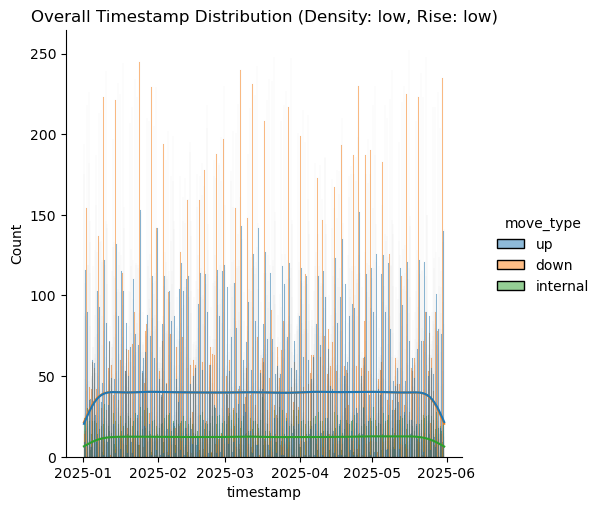

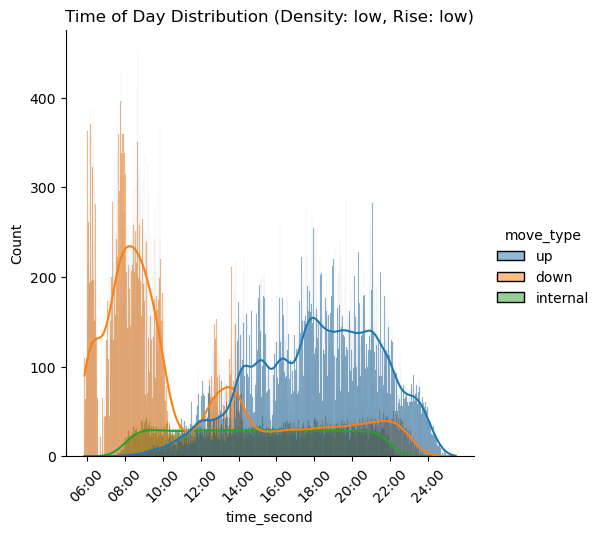

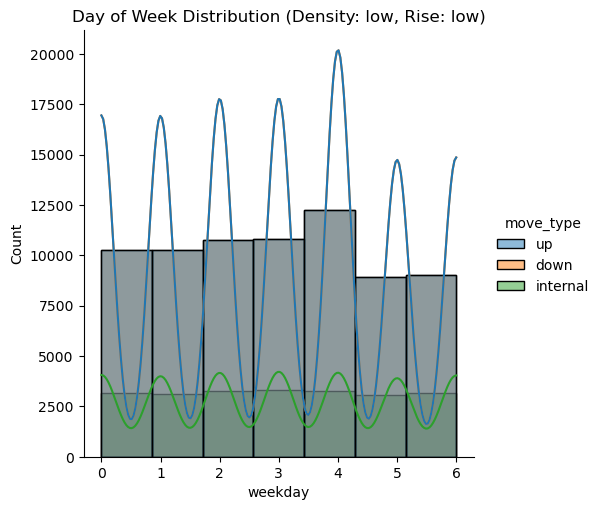

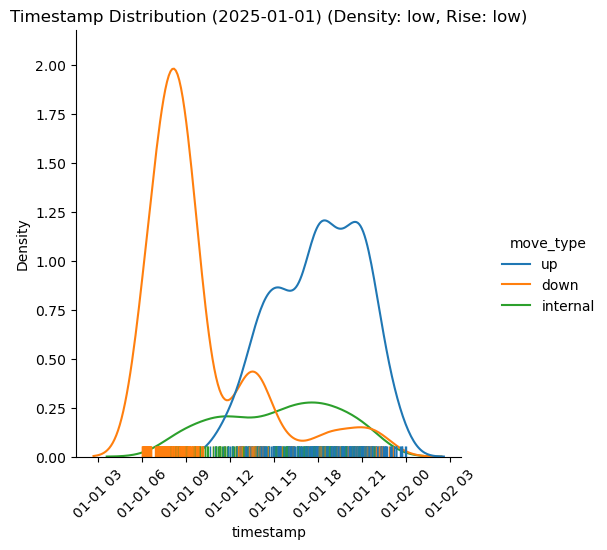

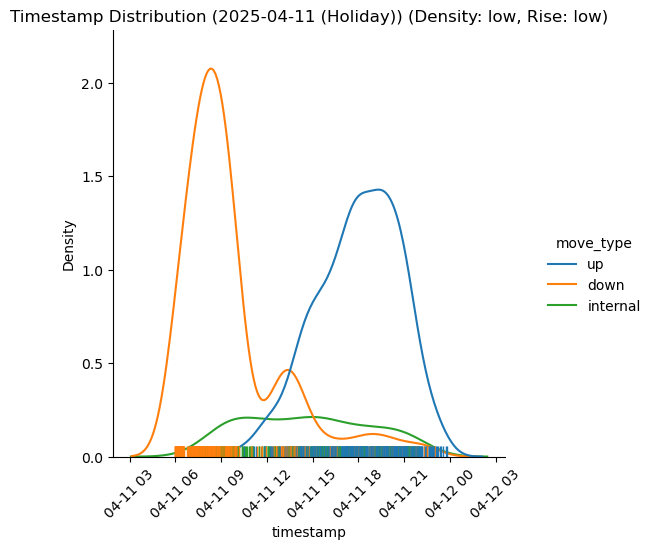

In [55]:
visualizing(low_rise_low_dense_arrivals,density='low', rise = 'low')